# Brazil soybeans crop model using Gro API
In this notebook, we walk through the process of building a simple "crop model" using data in Gro. The accompanying Gro web app display for [Brazil Soybeans](https://app.gro-intelligence.com/displays/25894) provides an overview of the data series we will use. The crop model we will create is a very basic  model that uses crop-production-weighted NDVI to forecast  yield.

## Preliminary
The fist step is to construct a `CropModel` object. We also save the entity ids for the `item` [soybeans](https://app.gro-intelligence.com/dictionary/items/270) and for the `region` [Brazil](https://app.gro-intelligence.com/dictionary/regions/1029).  We will use these throughout the notebook to simplify the retrieval, storage and manipulation of data.

In [1]:
import os
from api.client.crop_model import CropModel

model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])
country_id = model.search_for_entity('regions', "brazil")
crop_id =  model.search_for_entity('items', "soybeans")

##  Historical yields
To get data series for national level soybeans yield for Brazil, we set the item, metric and region entities, and get all the available data series.  Note that there are multiple data series in this case because there are a few different <em>sources</em> that report the Brazil soybeans yields: [FAO](https://app.gro-intelligence.com/dictionary/sources/2), [PS&D](https://app.gro-intelligence.com/dictionary/sources/14) and [IGC](https://app.gro-intelligence.com/dictionary/sources/19). Each source covers a slightly different time range. Here we simply take all of them to have maximum coverage.

In [2]:
yield_entities = {}
yield_entities['item_id']  = crop_id
yield_entities['region_id'] = country_id
yield_entities['metric_id'] = model.search_for_entity('metrics', "yield mass/area")
data_series_list = model.get_data_series(**yield_entities)
print("There are {} data series for {}.".format(len(data_series_list), yield_entities))
for data_series in data_series_list:
    print("source_id {}: {} to {}".format(
        data_series['source_id'], data_series['start_date'], data_series['end_date']))
    model.add_single_data_series(data_series)

There are 3 data series for {'item_id': 270, 'region_id': 1029, 'metric_id': 170037}.
source_id 2: 1961-01-01T00:00:00.000Z to 2017-12-31T00:00:00.000Z
source_id 14: 1978-01-01T00:00:00.000Z to 2019-12-31T00:00:00.000Z
source_id 19: 2003-01-01T00:00:00.000Z to 2017-12-31T00:00:00.000Z


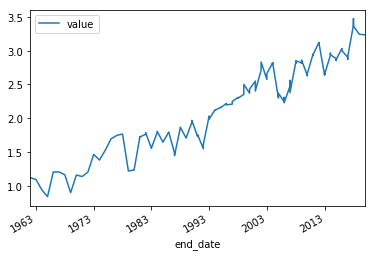

In [3]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt

df = model.get_df()
yield_df = df.loc[(df.metric_id == yield_entities['metric_id']) & \
                  (df.region_id == yield_entities['region_id'])]
yield_df.end_date = pandas.to_datetime(yield_df.end_date)
yield_df.set_index('end_date')
fig, axes = plt.subplots(1, 1)
yield_df.plot(x='end_date', y='value', ax=axes)
plt.ylabel("Yield (t/ha)")
plt.show()

## Production "weight" of provinces
We compute the "weight" of each province, based on the full history of production quantity per province. The weights are normalized to add up to 1.0. A weight of 0.2 means we expect that province to account for 20% of the country's production.

In [4]:
provinces = model.get_provinces("brazil")
weights = model.compute_weights("soybeans", "Production Quantity mass", provinces)
max_weight = max(filter(lambda x: x >0, weights))
print ('Total weight: {}'.format(sum(filter(lambda x: x >0, weights))))
print ('Maximum weight: {}'.format(max_weight))

Total weight: 1.0
Maximum weight: 0.245696688762


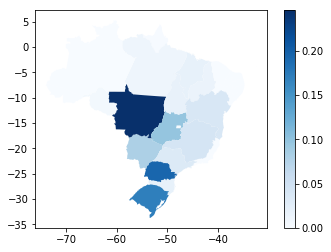

In [5]:
import geopandas
from shapely.geometry import shape

gdf = geopandas.GeoDataFrame([{
       'region_id': province['id'], 
       'geometry': shape(model.get_geojson(province['id'])['geometries'][0]),
       'production_weight': weight if weight > 0 else 0
    } for (province, weight) in zip(provinces, weights)])
gdf.set_index('region_id')

fig, axes = plt.subplots(1, 1)
gdf.plot(column='production_weight', 
         cmap='Blues', ax=axes, vmin=0, vmax=max_weight)
plt.show()

## NDVI, province level
The main signal we will use to model crop yields is [NDVI](https://app.gro-intelligence.com/dictionary/items/321). First we load the historical data for province level NDVI.  Here, there  are actually two data series for each region, one with `8-day` and one with `16-day` periods. We choose to use the series with 8-day (frequency_id = 3).

In [6]:
entities = {}
entities['item_id'] =  model.search_for_entity('items', "Vegetation NDVI")
entities['metric_id'] = model.search_for_entity('metrics', "Vegetation Indices index")
entities['frequency_id'] = 3

for province in provinces:
    entities['region_id'] = province['id']
    for data_series in model.get_data_series(**entities):
        model.add_single_data_series(data_series)

## NDVI crop-weighted, province level
NDVI represents the biomass  of <em>all</em> vegetation, not just soybeans. To make it a more accurate signal, we compute the crop-weighted version of NDVI.

In [7]:
soy_ndvi_df = model.compute_crop_weighted_series(
    'soybeans', 'Production Quantity mass',
    'Vegetation NDVI', 'Vegetation Indices index',
    provinces)


Now let's look at NDVI by province, on a particular date. First, we select NDVI for all provinces from the model's dataframe, and join it with the geopandas dataframe that has the provinces geometry.   Second, we select the crop weighted NDVI for all provinces from the `soy_ndvi_df` dataframe and do the same.

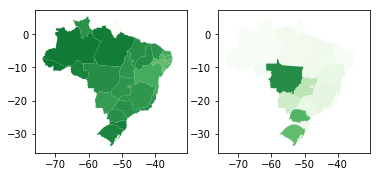

In [8]:
EVAL_DATE = u'2019-02-25T00:00:00.000Z'
df = model.get_df()
ndvi_df = df.loc[(df.metric_id == entities['metric_id']) & \
                 (df.end_date == EVAL_DATE),:]
gdf1 = gdf.join(ndvi_df.set_index('region_id'), on='region_id')

cwndvi_df = soy_ndvi_df.loc[(soy_ndvi_df.metric_id == entities['metric_id']) & \
                            (soy_ndvi_df.end_date == EVAL_DATE), :]
gdf2 = gdf.join(cwndvi_df.set_index('region_id'), on='region_id')

fig, axes = plt.subplots(1, 2)
gdf1.plot(column='value', 
          cmap='Greens', ax=axes[0], vmin=0.0, vmax=1.0)
gdf2.plot(column='value', 
          cmap='Greens', ax=axes[1], vmin=0.0, vmax=max_weight)
plt.show()

## NDVI, country level
NDVI is available as a data series at all region levels, so we just add it to the model at the country level.

In [9]:
entities['region_id'] = country_id
for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)
df = model.get_df()
df.end_date = pandas.to_datetime(df.end_date, utc=True)
country_ndvi_df = df.loc[(df.metric_id == entities['metric_id']) & \
                         (df.region_id == entities['region_id'])]

For crop weighted NDVI, we need to aggregate it up from provinces. Since the crop-weighted NDVI series was built with weights normalized to 1.0, the sum of province level values is the national level value, for each date.

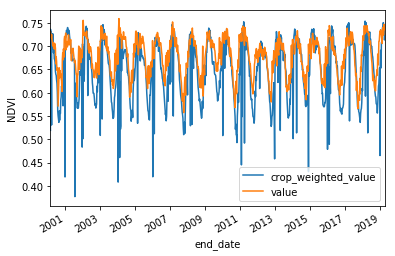

In [10]:
soy_ndvi_df.end_date = pandas.to_datetime(soy_ndvi_df.end_date, utc=True)
soy_ndvi_df.set_index('end_date')
country_ndvi_df.set_index('end_date')

country_ndvi_df = country_ndvi_df.merge(pandas.DataFrame([{
    'end_date': end_date,
    'crop_weighted_value': value
} for (end_date, value) in zip(soy_ndvi_df.end_date, 
                               soy_ndvi_df.groupby(['end_date']).sum().value)]))

fig, axes = plt.subplots(1, 1)
country_ndvi_df.plot(x='end_date', y=['crop_weighted_value', 'value'], ax=axes)
plt.ylabel('NDVI')
plt.show()

In [11]:
print soy_ndvi_df.shape
print df.shape

(23133, 12)
(24740, 12)


## Relationship between  yield and crop-weighted NDVI
On any day during the season, we can look at crop weighted NDVI as a rough aproximation of the amount of soybeans being grown. Let's see if this would work as a predictor of the final yield of the crop for the current year. For this example, we pick February 25th of each year, which, as we can see from the crop calendar for this crop on our [display](https://app.gro-intelligence.com/displays/25894), is the end of the growth period, and just before harvesting starts.  This date is late enough in the season (end of growth) that the weighted NDVI should represent the final amount of the crop that will be produced, but it is early enough (before harvest) for the forecast to be useful.  Let's look at a scatter plot of historical values of  crop weighted NDVI on Feb 25 and final yields for the same year.

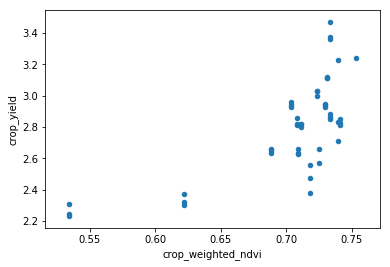

In [12]:
PREDICTION_DATE_MONTH = 2
PREDICTION_DATE_DAY = 25
tmp_df = country_ndvi_df.loc[(country_ndvi_df.metric_id == entities['metric_id']) & \
                             (country_ndvi_df.region_id == country_id) & \
                             (country_ndvi_df.end_date.map(lambda x: x.month) == PREDICTION_DATE_MONTH) &\
                             (country_ndvi_df.end_date.map(lambda x: x.day) == PREDICTION_DATE_DAY),:]
ym_df = pandas.DataFrame([{'year': end_date.year, 'crop_yield': value}
                          for (end_date, value) in zip(yield_df.end_date, 
                                                   yield_df.value)])
cw_df = pandas.DataFrame([{'year': end_date.year, 'crop_weighted_ndvi': value}
                          for (end_date, value) in zip(tmp_df.end_date,
                                                       tmp_df.crop_weighted_value)])
ym_df = ym_df.merge(cw_df)
ym_df.plot.scatter(x='crop_weighted_ndvi', y = 'crop_yield')
plt.show()                  

Indeed there seems to be a relationship between these two series, which means weighted NDVI on Feb 25 can be a reasonable predictor of final yield.

## Linear regression
An obvious next step is to do a linear regression, where we model `y = a * x + b` where x is the crop weighted NDVI.

(2.2302999999999997, 3.47)

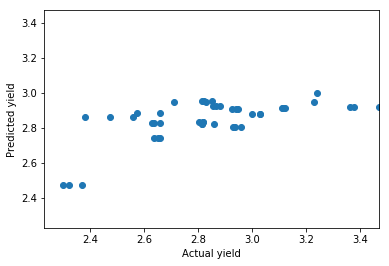

In [20]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
X = ym_df.loc[:,['crop_weighted_ndvi']]
lm.fit(X, ym_df.crop_yield)
plt.scatter(ym_df.crop_yield, lm.predict(X))
plt.xlabel("Actual yield")
plt.ylabel("Predicted yield (t/ha)")
llim = ym_df.crop_yield.min()
ulim = ym_df.crop_yield.max()
plt.xlim(llim, ulim)
plt.ylim(llim, ulim)

Not a great fit, especially at higher yields. This is not too surprising since we're using crop weights based on production rather than planted area.

## Polynomial regression
A polynomial of degree 2 should provide a better fit, i.e.  `y = a * x^2 + b * x + c` where x is the  crop weighted NDVI. Since there appears to be a longer term trend of improvement in yields as well, we add the year as another dependent variable. So the model becomes `y = a * x^2 + b * x + c + d * t`, where t is time (year).

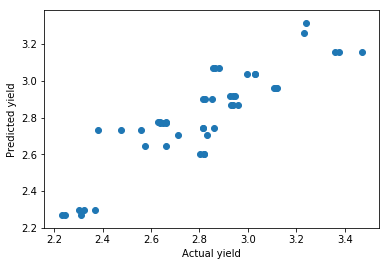

In [14]:
mean_yield = ym_df.crop_yield.mean()
X2 = pandas.DataFrame(X.crop_weighted_ndvi.map(lambda x: x*x))
X2.rename(columns={'crop_weighted_ndvi': 'crop_weighted_ndvi2'}, inplace=True)
X2 = pandas.DataFrame([X2.crop_weighted_ndvi2, X.crop_weighted_ndvi, ym_df.year]).transpose()
qm = linear_model.LinearRegression()
qm.fit(X2, ym_df.crop_yield)
qm_df =pandas.DataFrame([{'year': year, 'predicted_crop_yield': value}
                         for (year, value) in zip(ym_df.year, qm.predict(X2))])
plt.scatter(ym_df.crop_yield, (qm_df.predicted_crop_yield))
plt.xlabel("Actual yield (t/ha)")
plt.ylabel("Predicted yield (t/ha)")
plt.show()

This provides a better looking fit. Examining the error statistics confirms that.

In [15]:
from sklearn.metrics import mean_squared_error
print mean_squared_error(ym_df.crop_yield, lm.predict(X))
print mean_squared_error(ym_df.crop_yield, qm.predict(X2))


0.04346358724948868
0.019458817273240545


## Conclusion
A full blown model requires a lot more signals. For example, we would use district level historical yields, as well as [evapotranspiration](https://app.gro-intelligence.com/dictionary/items/4395) as additional inputs. 
But this extremely simple crop model shows that a reasonable quick prediction can be made just using historical yields, production and NDVI.

##  Related links
- Gro web app [display](https://app.gro-intelligence.com/displays/25894) accompanying this example
- Soybean kit section of the [user manual](https://app.gro-intelligence.com/docs/user-manual#weather-data-soybean)
- Gro Yield Model [source in Gro](https://app.gro-intelligence.com/dictionary/sources/32), [web page and papers](https://gro-intelligence.com/yield-model/)